In [1]:
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

import import_ipynb
from base.models import StatEcoNet_H1

importing Jupyter notebook from /scratch/Eugene/codes/grt_hist/tmp/StatEcoNet-AAAI21/StatEcoNet/base/models.ipynb


# Load data files

In [2]:
# Define the dataset
df_occ = pd.read_csv("../data/Synthetic/multi_ks/df_occ.csv")
df_det = pd.read_csv("../data/Synthetic/multi_ks/df_det.csv")

# Train/evalute the model

In [6]:
x_dim = 10
w_dim = 10

lr = 0.001
bs = 100
nN = 8
n_epoch = 1000

# StatEcoNet with one hidden layer
model = StatEcoNet_H1(x_dim, w_dim, nN)

# For mini batches
params = {'batch_size': bs,
          'shuffle': True,
          'num_workers': 1}

dataset = TensorDataset(torch.tensor(np.array(df_occ.site_index)))  
dataloader = DataLoader(dataset, **params)

# Set an optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [7]:
def my_loss_function_multi_ks(A, B):  
    log_A_plus_B = torch.log(torch.stack(A) + torch.stack(A))
    if torch.sum(torch.isinf(log_A_plus_B)):
        log_A_plus_B[(log_A_plus_B<=0)] = torch.log(torch.tensor(1e-45))
    loss = -torch.mean(log_A_plus_B)
    return loss

Text(0.5, 1.0, 'Training Loss')

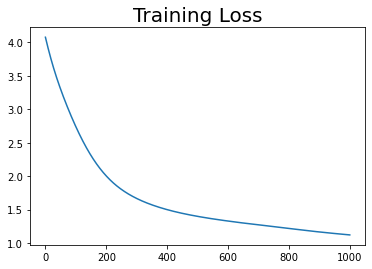

In [8]:
train_loss = []
for i in tqdm(range(n_epoch)):        
    model.train()
    optimizer.zero_grad()
    for i_batch, data in enumerate(dataloader):                         
        A = [] # the first component in the log-likelihood function
        B = [] # the second component in the log-likelihood function        
        
        # Load a minibatch 
        for i in data[0]: # for each survey 
            # 1. obtain the corresponding site features, x
            x = torch.tensor(np.array(df_occ.iloc[int(i)][4:]), dtype=torch.float32).reshape(1, x_dim)
            # 2. obtain all surveys of the site
            surveys = df_det[df_det['site_index']==int(i)]            
            # 3. obtain the survey features, w
            w = torch.tensor(np.array(surveys)[:, 4:], dtype=torch.float32).reshape(1, len(surveys), w_dim)             
            # 4. obtain the observation states of the surveys
            surveys_y = torch.tensor(np.array(surveys.observed), dtype=torch.float32)            
            # 5. indication of whether all observations were zero at the site
            maybe_absent = not sum(surveys['observed'])
            
            # Train the model with the site (x) and survey (w) features
            psi_hat_train, p_hat_train = model(x, w)
            
            # Compute the log-likelihood function
            likelihood = psi_hat_train * \
                         torch.prod(\
                            torch.distributions.bernoulli.Bernoulli(\
                            probs=p_hat_train.reshape(1,len(surveys))).log_prob(surveys_y).exp(), 1)
            A.append(likelihood[0][0]) 
            B.append(((1-psi_hat_train) * maybe_absent)[0][0])
            
        # Compute training loss
        loss = my_loss_function_multi_ks(A, B)     
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

plt.plot(train_loss)
plt.title("Training Loss", fontsize = 20)